## Setup
Import the necessary libraries and a few helper functions.

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import json
import datetime as dt

import cv2
import math
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14

import tensorflow as tf
import keras

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dense, Dropout, Flatten, Activation

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam

from keras.applications import *
from keras.applications.mobilenet import preprocess_input

start = dt.datetime.now()

Using TensorFlow backend.


In [2]:
DP_DIR = 'shuffle_csvs/'
INPUT_DIR = '../input/'
timestamp = dt.datetime.now().strftime("%d-%H%M%S")

NCSVS = 200
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

In [3]:
def f2cat(filename: str) -> str: return filename.split('.')[0]
def list_all_categories(): return sorted([f2cat(f) for f in os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))], key=str.lower)
def apk(actual, predicted, k=3):
    if len(predicted) > k: predicted = predicted[:k]
    score, num_hits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if len(actual)==0: return 0.0
    return score / min(len(actual), k)
def mapk(actual, predicted, k=3): return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])
def preds2catids(predictions): return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])
def top_3_accuracy(y_true, y_pred): return top_k_categorical_accuracy(y_true, y_pred, k=3)
log_keys = ('loss', 'val_loss', 'categorical_accuracy', 'top_3_accuracy', 'val_categorical_accuracy', 'val_top_3_accuracy')
def print_history(hist): print("\t".join(["%s:%.3f"%(key, hist.history[key][-1]) for key in log_keys]))

In [4]:
def visualize_history(hists, img_file):
    hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
    hist_df.index = np.arange(1, len(hist_df)+1)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    
    plots = [('Validation Accuracy',     hist_df.val_categorical_accuracy),
            ('Training Accuracy',        hist_df.categorical_accuracy),
            ('Training Top3 Accuracy',   hist_df.top_3_accuracy),
            ('Validation Top3 Accuracy', hist_df.val_top_3_accuracy),
            ('Validation MLogLoss',      hist_df.val_loss),
            ('Training MLogLoss',        hist_df.loss)]
    
    for label, data in plots[:4]: axs[0].plot(data, label=label, lw=3)
    for label, data in plots[4:]: axs[1].plot(data, label=label, lw=3)

    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    
    axs[1].set_ylabel('MLogLoss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    fig.savefig(img_file, dpi=300)
    plt.show();

## MobileNet

MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)

In [5]:
time_color = True
stroke_size = 3

sampler = {image_size:[round(i*(image_size-10)/256)+5 for i in range(512)] for image_size in [128, 224, 299, 331]}
stroke_color = defaultdict(lambda: 125 if time_color else 255,
        {t:255-min(t,10)*13 for t in range(10)} if time_color else {})

In [6]:
def draw_cv2(img, raw_strokes, image_size): 
    for t in range(len(raw_strokes)-1, -1, -1):
        stroke = raw_strokes[t]
        for i in range(len(stroke[0]) - 1):
            cv2.line(img,
                (sampler[image_size][stroke[0][i]],   sampler[image_size][stroke[1][i]]),
                (sampler[image_size][stroke[0][i+1]], sampler[image_size][stroke[1][i+1]]),
                stroke_color[i], stroke_size)

In [7]:
def image_generator_xd(batchsize, ks, image_size):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df.drawing = df.drawing.apply(json.loads)
                
                x = np.zeros((len(df), image_size, image_size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    draw_cv2(x[i], raw_strokes, image_size)
                x = np.repeat(x, 3, axis=3)
                x = preprocess_input(x).astype(np.float32)
                
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

In [8]:
def image_generator_test(filename, batchsize, image_size):
    for df in pd.read_csv(filename, chunksize=batchsize):
        df.drawing = df.drawing.apply(json.loads)

        x = np.zeros((len(df), image_size, image_size, 1))
        for i, raw_strokes in enumerate(df.drawing.values):
            draw_cv2(x[i], raw_strokes, image_size)
        x = np.repeat(x, 3, axis=3)
        x = preprocess_input(x).astype(np.float32)

        yield x

In [9]:
def filenames(modelname):
    description = "%s.%s"%(modelname, timestamp)
    img_file    = "%s.png"%description
    hist_csv    = "%s.csv"%description
    submission  = "%s_submission.csv"%description
    return description, img_file, hist_csv, submission

In [10]:
BATCHSIZE = 128
STEPS     = 2000
VSTEPS    = 500
EPOCHS    = 10

# Running the model

In [11]:
def generate_model(model_generator, load_weights=None, freeze=None):
    model = model_generator(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    if freeze is not None:
        for i, layer in enumerate(model.layers):
            if i in freeze: layer.trainable = False
            else: layer.trainable = True
    
    out = model.output
    out = GlobalAveragePooling2D()(out)
    out = Dense(1000, activation="relu")(out)
    out = Dense(NCATS, activation="softmax")(out)

    model = Model(model.input, out)
    if load_weights is not None:
        model.load_weights(load_weights)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy',
                  metrics=[categorical_accuracy, top_3_accuracy])
    return model

In [12]:
def retrain_model(modelname, model, batchsize=BATCHSIZE, steps=STEPS, val_steps=VSTEPS, epochs=EPOCHS):
    start = dt.datetime.now()
    train_datagen = image_generator_xd(batchsize, range(190), 128)
    valid_datagen = image_generator_xd(batchsize, range(190, 200), 128)
    filepath      = os.path.join(INPUT_DIR, 'test_simplified.csv')
    test_datagen  = image_generator_test(filepath, batchsize, 128)
    
    
    description, img_file, hist_csv, submission_csv = filenames(modelname)
    callbacks = [
        ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                          min_delta=0.005, mode='max', cooldown=3, verbose=1),
        ModelCheckpoint("%s-{epoch:02d}-{val_loss:.2f}.h5"%description,
                        monitor='val_categorical_accuracy',
                        save_weights_only=True, mode='auto', period=1),
        keras.callbacks.CSVLogger(hist_csv, separator=',', append=True)]
    
    hist = model.fit_generator(
        train_datagen,
        validation_data=valid_datagen, validation_steps=val_steps, 
        steps_per_epoch=steps, epochs=epochs, verbose=1,
        callbacks = callbacks
    )
    
    print("Visualizing training history")
    print_history(hist)
    visualize_history([hist], img_file)
    
    print("Generating map3 score")
    # Get map3 score
    maps = []
    for i in range(50):
        x_valid, y_valid = next(valid_datagen)
        valid_predictions = model.predict(x_valid)
        map3 = mapk(np.argmax(y_valid, axis=1).reshape(-1,1), preds2catids(valid_predictions).values)
        maps.append(map3)
    map3 = np.array(maps).mean()
    print('Computed Map3 Score on Validation set: {:.3f}'.format(map3))
    
    # Run test predictions
    # TODO Refactor
    test_predictions = model.predict_generator(test_datagen, steps=int(100/batchsize)+1)
    test = pd.read_csv(filepath)
    top3 = preds2catids(test_predictions)

    cats = list_all_categories()
    id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
    top3cats = top3.replace(id2cat)
    
    test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
    submission = test[['key_id', 'word']]
    submission.to_csv(submission_csv, index=False)
    print("Submission output to %s", submission_csv, submission.shape)
    
    end = dt.datetime.now()
    print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

# Pretrained models

In [13]:
BATCHSIZE = 128
STEPS     = 2000
VSTEPS    = 500
EPOCHS    = 10
props256  = dict(batchsize=256, steps=1000, val_steps=500, epochs=10)
props128  = dict(batchsize=128, steps=2000, val_steps=500, epochs=10)
props64   = dict(batchsize=64,  steps=4000, val_steps=500, epochs=10)     

# Xception V1 model

Max batch size on GPU = 64

Epoch 1/10
4000/4000 [==============================] - 1108s 277ms/step - loss: 2.2850 - categorical_accuracy: 0.4670 - top_3_accuracy: 0.6658 - val_loss: 1.5930 - val_categorical_accuracy: 0.6045 - val_top_3_accuracy: 0.8054
Epoch 2/10
4000/4000 [==============================] - 1099s 275ms/step - loss: 1.4442 - categorical_accuracy: 0.6366 - top_3_accuracy: 0.8269 - val_loss: 1.3817 - val_categorical_accuracy: 0.6527 - val_top_3_accuracy: 0.8373
Epoch 3/10
4000/4000 [==============================] - 1098s 275ms/step - loss: 1.3001 - categorical_accuracy: 0.6705 - top_3_accuracy: 0.8500 - val_loss: 1.2970 - val_categorical_accuracy: 0.6752 - val_top_3_accuracy: 0.8488
Epoch 4/10
4000/4000 [==============================] - 1098s 275ms/step - loss: 1.2089 - categorical_accuracy: 0.6928 - top_3_accuracy: 0.8639 - val_loss: 1.1880 - val_categorical_accuracy: 0.6991 - val_top_3_accuracy: 0.8688
Epoch 5/10
4000/4000 [==============================] - 1088s 272ms/step - loss: 1.1518 - ca

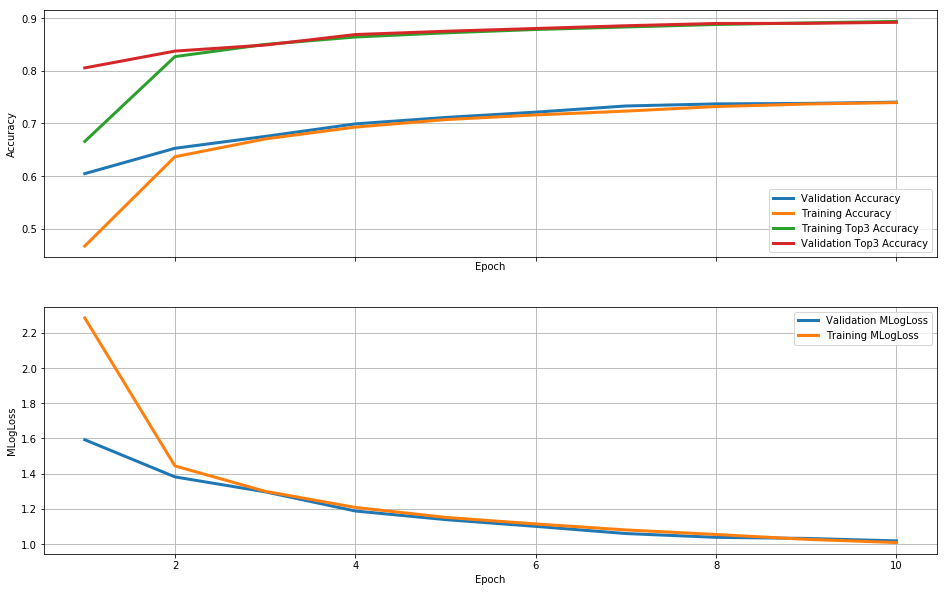

Generating map3 score
Computed Map3 Score on Validation set: 0.800
Submission output to %s Xception.02-071834_submission.csv (112199, 2)
Latest run 2018-12-02 11:27:43.767484.
Total time 11007s


In [15]:
model = generate_model(xception.Xception)
retrain_model("Xception", model, **props64 )

# VGG 16

Epoch 1/10
2000/2000 [==============================] - 312s 156ms/step - loss: 2.7066 - categorical_accuracy: 0.4014 - top_3_accuracy: 0.5947 - val_loss: 2.1525 - val_categorical_accuracy: 0.4973 - val_top_3_accuracy: 0.7009
Epoch 2/10
2000/2000 [==============================] - 309s 154ms/step - loss: 2.0207 - categorical_accuracy: 0.5225 - top_3_accuracy: 0.7239 - val_loss: 1.9199 - val_categorical_accuracy: 0.5420 - val_top_3_accuracy: 0.7414
Epoch 3/10
2000/2000 [==============================] - 308s 154ms/step - loss: 1.8634 - categorical_accuracy: 0.5539 - top_3_accuracy: 0.7518 - val_loss: 1.8290 - val_categorical_accuracy: 0.5620 - val_top_3_accuracy: 0.7596
Epoch 4/10
2000/2000 [==============================] - 309s 154ms/step - loss: 1.7803 - categorical_accuracy: 0.5722 - top_3_accuracy: 0.7667 - val_loss: 1.7474 - val_categorical_accuracy: 0.5799 - val_top_3_accuracy: 0.7736
Epoch 5/10
2000/2000 [==============================] - 308s 154ms/step - loss: 1.7247 - categor

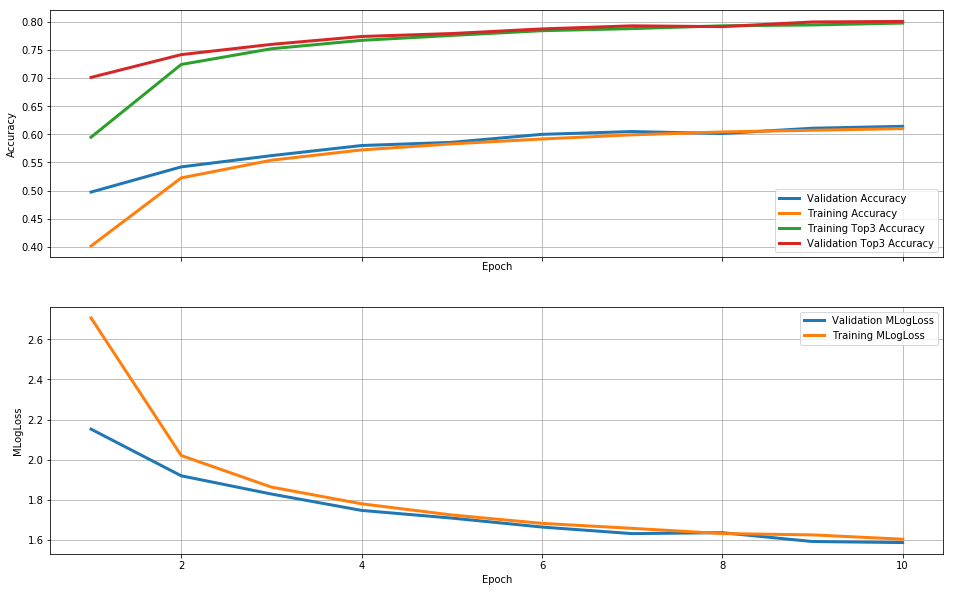

Generating map3 score
Computed Map3 Score on Validation set: 0.694
Submission output to %s VGG16.02-214836_submission.csv (112199, 2)
Latest run 2018-12-02 22:40:24.835323.
Total time 3102s


In [14]:
model = generate_model(vgg16.VGG16, freeze=set(range(18)))
retrain_model("VGG16", model, batchsize=128, steps=2000, val_steps=500, epochs=10)

# VGG 19

In [ ]:
model = generate_model(vgg19.VGG19, freeze=set(range(18)))
retrain_model("VGG19", model, batchsize=128, steps=2000, val_steps=500, epochs=10)

Epoch 1/10
2000/2000 [==============================] - 391s 195ms/step - loss: 5.8295 - categorical_accuracy: 0.0029 - top_3_accuracy: 0.0087 - val_loss: 5.8294 - val_categorical_accuracy: 0.0027 - val_top_3_accuracy: 0.0086
Epoch 2/10
2000/2000 [==============================] - 390s 195ms/step - loss: 5.8293 - categorical_accuracy: 0.0029 - top_3_accuracy: 0.0089 - val_loss: 5.8293 - val_categorical_accuracy: 0.0030 - val_top_3_accuracy: 0.0095
Epoch 3/10
2000/2000 [==============================] - 390s 195ms/step - loss: 5.8294 - categorical_accuracy: 0.0028 - top_3_accuracy: 0.0089 - val_loss: 5.8295 - val_categorical_accuracy: 0.0028 - val_top_3_accuracy: 0.0086
Epoch 4/10
2000/2000 [==============================] - 390s 195ms/step - loss: 5.8294 - categorical_accuracy: 0.0029 - top_3_accuracy: 0.0086 - val_loss: 5.8293 - val_categorical_accuracy: 0.0031 - val_top_3_accuracy: 0.0096
Epoch 5/10
1636/2000 [=======================>......] - ETA: 58s - loss: 5.8292 - categorical_ac

# ResNet50

Max batch size on GPU = 64

C:\Users\ps2958\Anaconda3\envs\tf-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/10
4000/4000 [==============================] - 807s 202ms/step - loss: 2.0483 - categorical_accuracy: 0.5148 - top_3_accuracy: 0.7140 - val_loss: 1.6533 - val_categorical_accuracy: 0.5927 - val_top_3_accuracy: 0.7917
Epoch 2/10
4000/4000 [==============================] - 795s 199ms/step - loss: 1.4075 - categorical_accuracy: 0.6486 - top_3_accuracy: 0.8333 - val_loss: 1.4935 - val_categorical_accuracy: 0.6299 - val_top_3_accuracy: 0.8164
Epoch 3/10
4000/4000 [==============================] - 782s 196ms/step - loss: 1.2758 - categorical_accuracy: 0.6789 - top_3_accuracy: 0.8539 - val_loss: 1.3854 - val_categorical_accuracy: 0.6538 - val_top_3_accuracy: 0.8397
Epoch 4/10
4000/4000 [==============================] - 795s 199ms/step - loss: 1.2073 - categorical_accuracy: 0.6971 - top_3_accuracy: 0.8642 - val_loss: 1.2120 - val_categorical_accuracy: 0.6930 - val_top_3_accuracy: 0.8624
Epoch 5/10
4000/4000 [==============================] - 782s 196ms/step - loss: 1.1608 - categor

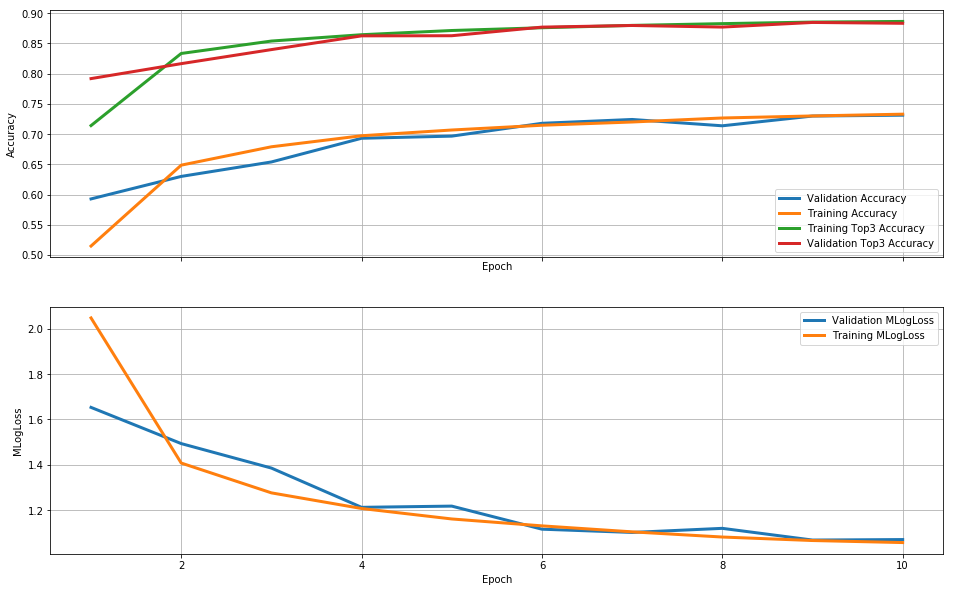

Generating map3 score
Computed Map3 Score on Validation set: 0.802
Submission output to %s ResNet50.02-071834_submission.csv (112199, 2)
Latest run 2018-12-02 18:15:37.954941.
Total time 7978s


In [18]:
model = generate_model(resnet50.ResNet50)
retrain_model("ResNet50", model, **props64)

# Inception V3

Epoch 1/10
2000/2000 [==============================] - 520s 260ms/step - loss: 2.1397 - categorical_accuracy: 0.4957 - top_3_accuracy: 0.6966 - val_loss: 1.6893 - val_categorical_accuracy: 0.5829 - val_top_3_accuracy: 0.7837
Epoch 2/10
2000/2000 [==============================] - 493s 247ms/step - loss: 1.4868 - categorical_accuracy: 0.6284 - top_3_accuracy: 0.8192 - val_loss: 1.4792 - val_categorical_accuracy: 0.6319 - val_top_3_accuracy: 0.8183
Epoch 3/10
2000/2000 [==============================] - 497s 248ms/step - loss: 1.3508 - categorical_accuracy: 0.6601 - top_3_accuracy: 0.8411 - val_loss: 1.4070 - val_categorical_accuracy: 0.6503 - val_top_3_accuracy: 0.8319
Epoch 4/10
2000/2000 [==============================] - 495s 247ms/step - loss: 1.2818 - categorical_accuracy: 0.6774 - top_3_accuracy: 0.8526 - val_loss: 1.3764 - val_categorical_accuracy: 0.6565 - val_top_3_accuracy: 0.8349
Epoch 5/10
2000/2000 [==============================] - 496s 248ms/step - loss: 1.2250 - categor

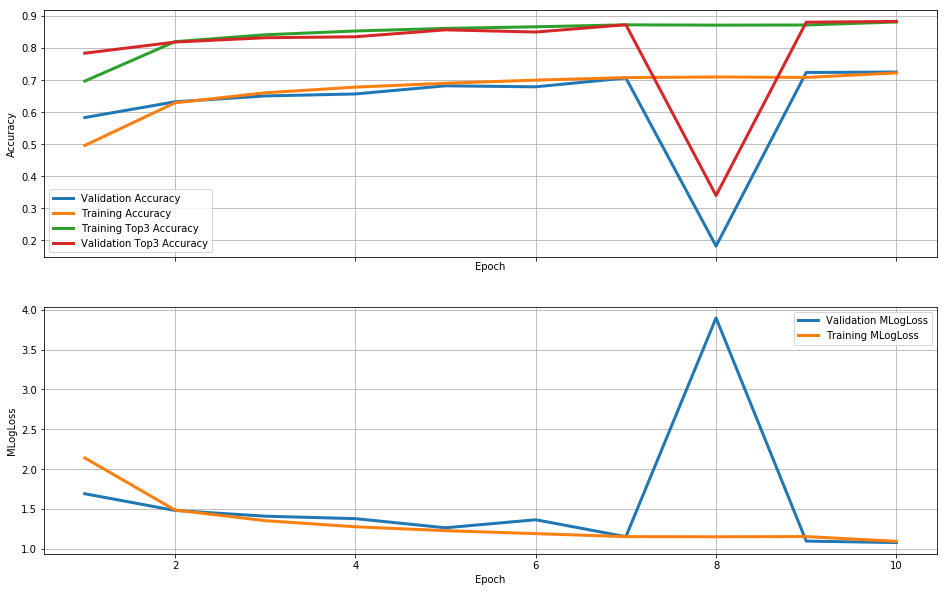

Generating map3 score
Computed Map3 Score on Validation set: 0.792
Submission output to %s InceptionV3.02-071834_submission.csv (112199, 2)
Latest run 2018-12-02 19:40:28.236890.
Total time 5072s


In [19]:
model = generate_model(inception_v3.InceptionV3)
retrain_model("InceptionV3", model, **props128)

# InceptionResNetV2

In [ ]:
model = generate_model(inception_resnet_v2.InceptionResNetV2)
retrain_model("InceptionResNetV2", model, batchsize=64,  steps=4000, val_steps=500, epochs=10)

Epoch 1/10
4000/4000 [==============================] - 1322s 330ms/step - loss: 2.0565 - categorical_accuracy: 0.5133 - top_3_accuracy: 0.7127 - val_loss: 1.6223 - val_categorical_accuracy: 0.6007 - val_top_3_accuracy: 0.7982
Epoch 2/10
4000/4000 [==============================] - 1290s 323ms/step - loss: 1.4189 - categorical_accuracy: 0.6455 - top_3_accuracy: 0.8311 - val_loss: 1.3734 - val_categorical_accuracy: 0.6578 - val_top_3_accuracy: 0.8392
Epoch 3/10
4000/4000 [==============================] - 1270s 317ms/step - loss: 1.2773 - categorical_accuracy: 0.6783 - top_3_accuracy: 0.8538 - val_loss: 1.2516 - val_categorical_accuracy: 0.6832 - val_top_3_accuracy: 0.8577
Epoch 4/10
4000/4000 [==============================] - 1273s 318ms/step - loss: 1.1913 - categorical_accuracy: 0.6977 - top_3_accuracy: 0.8673 - val_loss: 1.3557 - val_categorical_accuracy: 0.6840 - val_top_3_accuracy: 0.8518
Epoch 5/10
4000/4000 [==============================] - 1293s 323ms/step - loss: 1.1434 - ca

# MobileNet v1

Epoch 1/10
2000/2000 [==============================] - 393s 197ms/step - loss: 1.7676 - categorical_accuracy: 0.5741 - top_3_accuracy: 0.7698 - val_loss: 1.5520 - val_categorical_accuracy: 0.6154 - val_top_3_accuracy: 0.8103
Epoch 2/10
2000/2000 [==============================] - 388s 194ms/step - loss: 1.3224 - categorical_accuracy: 0.6665 - top_3_accuracy: 0.8464 - val_loss: 1.3124 - val_categorical_accuracy: 0.6681 - val_top_3_accuracy: 0.8485
Epoch 3/10
2000/2000 [==============================] - 388s 194ms/step - loss: 1.2166 - categorical_accuracy: 0.6909 - top_3_accuracy: 0.8634 - val_loss: 1.2167 - val_categorical_accuracy: 0.6909 - val_top_3_accuracy: 0.8620
Epoch 4/10
2000/2000 [==============================] - 387s 194ms/step - loss: 1.1624 - categorical_accuracy: 0.7044 - top_3_accuracy: 0.8717 - val_loss: 1.1491 - val_categorical_accuracy: 0.7062 - val_top_3_accuracy: 0.8737
Epoch 5/10
2000/2000 [==============================] - 387s 194ms/step - loss: 1.1240 - categor

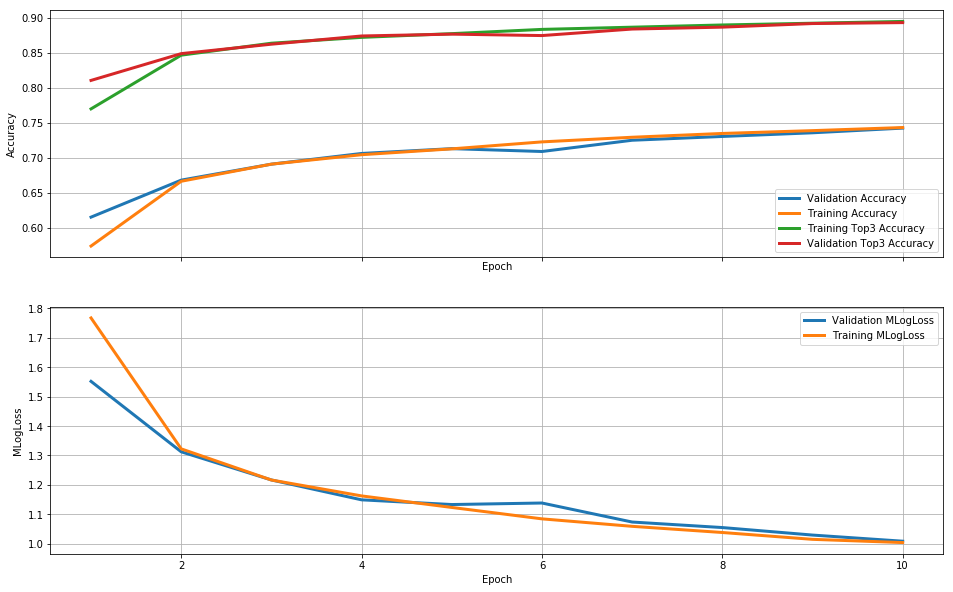

Generating map3 score
Computed Map3 Score on Validation set: 0.810
Submission output to %s MobileNetv1.02-071834_submission.csv (112199, 2)
Latest run 2018-12-02 08:24:09.802027.
Total time 3894s


In [14]:
model = generate_model(mobilenet.MobileNet)
retrain_model("MobileNetv1", model, **props128)

# MobileNet v2

Epoch 1/10
2000/2000 [==============================] - 497s 249ms/step - loss: 1.9118 - categorical_accuracy: 0.5392 - top_3_accuracy: 0.7426 - val_loss: 2.6820 - val_categorical_accuracy: 0.3930 - val_top_3_accuracy: 0.6134
Epoch 2/10
2000/2000 [==============================] - 482s 241ms/step - loss: 1.4136 - categorical_accuracy: 0.6443 - top_3_accuracy: 0.8336 - val_loss: 3.6390 - val_categorical_accuracy: 0.2298 - val_top_3_accuracy: 0.4186
Epoch 3/10
2000/2000 [==============================] - 483s 241ms/step - loss: 1.3069 - categorical_accuracy: 0.6722 - top_3_accuracy: 0.8498 - val_loss: 3.0729 - val_categorical_accuracy: 0.3062 - val_top_3_accuracy: 0.5169
Epoch 4/10
2000/2000 [==============================] - 483s 241ms/step - loss: 1.2423 - categorical_accuracy: 0.6844 - top_3_accuracy: 0.8600 - val_loss: 1.9886 - val_categorical_accuracy: 0.5213 - val_top_3_accuracy: 0.7313
Epoch 5/10
2000/2000 [==============================] - 483s 241ms/step - loss: 1.1870 - categor

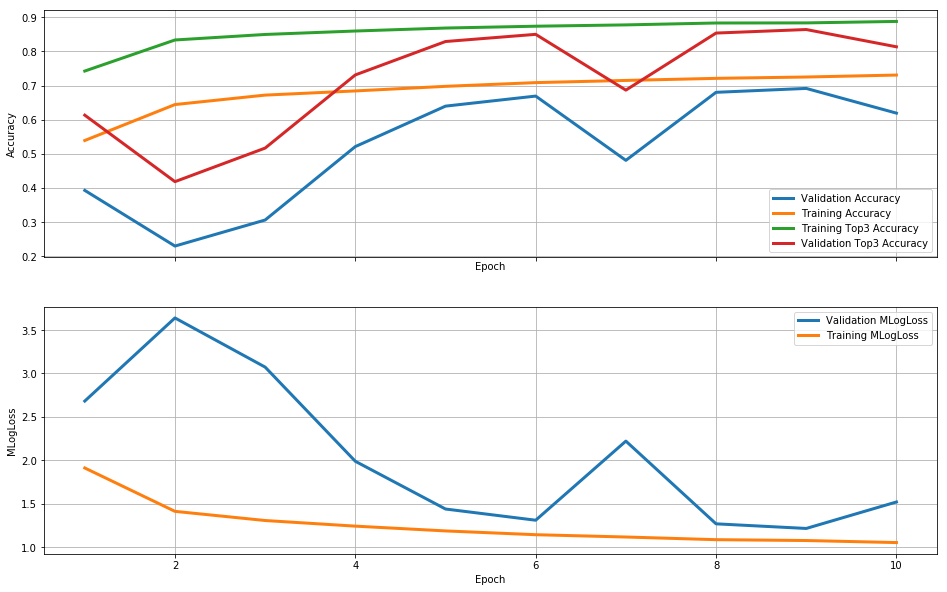

Generating map3 score
Computed Map3 Score on Validation set: 0.701
Submission output to %s MobileNetv2.02-071834_submission.csv (112199, 2)
Latest run 2018-12-02 21:07:19.876354.
Total time 5044s


In [21]:
model = generate_model(mobilenet_v2.MobileNetV2)
retrain_model("MobileNetv2", model, batchsize=128, steps=2000, val_steps=500, epochs=10)

# DenseNet

Max batch size on GPU = 64

In [ ]:
model = generate_model(densenet.DenseNet121)
retrain_model("DenseNet121", model, batchsize=64, steps=2000, val_steps=500, epochs=10)

Epoch 1/10
2000/2000 [==============================] - 515s 257ms/step - loss: 2.4117 - categorical_accuracy: 0.4413 - top_3_accuracy: 0.6445 - val_loss: 1.9588 - val_categorical_accuracy: 0.5216 - val_top_3_accuracy: 0.7408


In [ ]:
# model = generate_model(densenet.DenseNet169)
# retrain_model("DenseNet169", model, batchsize=64, steps=10, val_steps=1, epochs=1)

In [ ]:
# model = generate_model(densenet.DenseNet201)
# retrain_model("DenseNet201", model, batchsize=64, steps=10, val_steps=1, epochs=1)

# NASNet

Epoch 1/10
2000/2000 [==============================] - 342s 171ms/step - loss: 2.0076 - categorical_accuracy: 0.5178 - top_3_accuracy: 0.7235 - val_loss: 2.5292 - val_categorical_accuracy: 0.4122 - val_top_3_accuracy: 0.6262
Epoch 2/10
2000/2000 [==============================] - 321s 161ms/step - loss: 1.3722 - categorical_accuracy: 0.6529 - top_3_accuracy: 0.8375 - val_loss: 3.3118 - val_categorical_accuracy: 0.2881 - val_top_3_accuracy: 0.4810
Epoch 4/10
2000/2000 [==============================] - 323s 161ms/step - loss: 1.3044 - categorical_accuracy: 0.6697 - top_3_accuracy: 0.8478 - val_loss: 2.6651 - val_categorical_accuracy: 0.3948 - val_top_3_accuracy: 0.6129
Epoch 5/10
2000/2000 [==============================] - 322s 161ms/step - loss: 1.2571 - categorical_accuracy: 0.6801 - top_3_accuracy: 0.8549 - val_loss: 2.6083 - val_categorical_accuracy: 0.4098 - val_top_3_accuracy: 0.6165
Epoch 6/10
2000/2000 [==============================] - 323s 162ms/step - loss: 1.2275 - categor

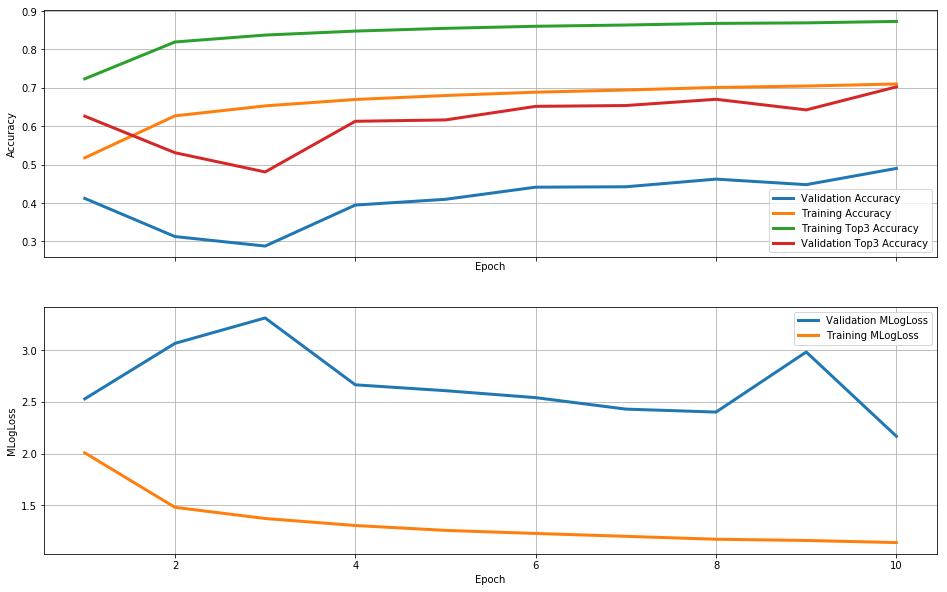

Generating map3 score
Computed Map3 Score on Validation set: 0.577
Submission output to %s NASNetMobile.02-231100_submission.csv (112199, 2)
Latest run 2018-12-03 00:16:23.329766.
Total time 3522s


In [22]:
model = generate_model(nasnet.NASNetMobile, freeze=set(range(500))) # Model has 772 layers
retrain_model("NASNetMobile", model, batchsize=128, steps=2000, val_steps=500, epochs=10)

In [ ]:
# model = generate_model(nasnet.NASNetLarge)
# retrain_model("NASNetLarge", model, batchsize=128, steps=10, val_steps=1, epochs=1 )